<h1>Edited Version of Enhancing Medical Image Quality Using Deep Learning Techniques Code</h1>


<h2> Evaluation Metrics:</h2>

<ul>
  <li>
    <strong> PSNR (Peak Signal-to-Noise Ratio)</strong><br>
    Measures pixel-wise fidelity to the original high-resolution image.<br>
    <em>Higher = Better</em>.
  </li>
  <br>
  <li>
    <strong> SSIM (Structural Similarity Index)</strong><br>
    Measures structural and perceptual similarity.<br>
    Considers luminance, contrast, and structure.<br>
    <em>Ranges from -1 to 1. Higher = Better</em>.
  </li>
</ul>

<h2>Changes Made To The Model</h2>

Due to the time constraints of the project, quality of each image had to be reduced by taking the image sizes from 128×128 to 64×64, which had 4× fewer pixels per image, allowing much faster training and less memory. More changes listed above.

<table border="1" cellpadding="8" cellspacing="0">
  <thead>
    <tr>
      <th>Category</th>
      <th>Change Made</th>
      <th>Purpose</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Model Handling</td>
      <td>Added loop over both models</td>
      <td>Run SRCNN and VDSR together</td>
    </tr>
    <tr>
      <td>Runtime</td>
      <td>Smaller images and fewer epochs</td>
      <td>Faster training</td>
    </tr>
    <tr>
      <td>Dataset</td>
      <td>Limited to 200 images</td>
      <td>Shorter load and train time</td>
    </tr>
    <tr>
      <td>Model Size</td>
      <td>VDSR depth cut to 10 layers</td>
      <td>Less computation, faster training</td>
    </tr>
    <tr>
      <td>Batch/Epochs</td>
      <td>Smaller batch and fewer epochs</td>
      <td>Reduce runtime and memory</td>
    </tr>
    <tr>
      <td>Structure</td>
      <td>Modular functions</td>
      <td>Easier reuse and expansion</td>
    </tr>
  </tbody>
</table>

Path to dataset files: /kaggle/input/sample

Running SRCNN...

Epoch 1/5
36/36 - 18s - 505ms/step - loss: 0.0985 - val_loss: 0.0216
Epoch 2/5
36/36 - 18s - 494ms/step - loss: 0.0178 - val_loss: 0.0133
Epoch 3/5
36/36 - 16s - 457ms/step - loss: 0.0085 - val_loss: 0.0053
Epoch 4/5
36/36 - 22s - 612ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/5
36/36 - 20s - 545ms/step - loss: 0.0030 - val_loss: 0.0030
Model: SRCNN, PSNR: 25.85, SSIM: 0.8729
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


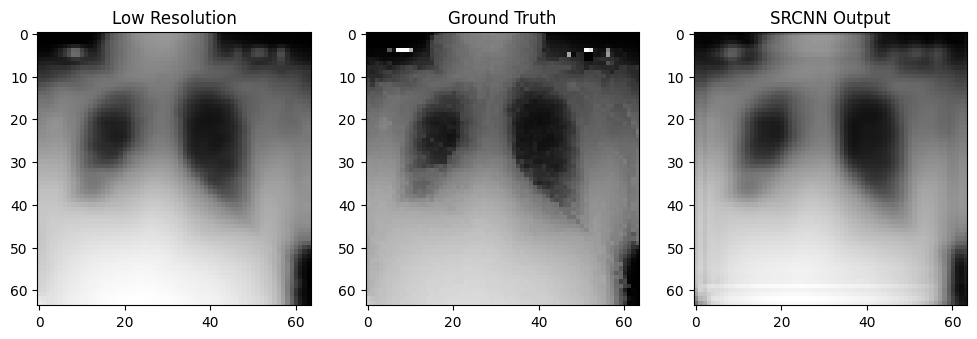


Running VDSR...

Epoch 1/5
36/36 - 64s - 2s/step - loss: 0.0019 - val_loss: 0.0019
Epoch 2/5
36/36 - 82s - 2s/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/5
36/36 - 83s - 2s/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/5
36/36 - 79s - 2s/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/5
36/36 - 83s - 2s/step - loss: 0.0015 - val_loss: 0.0014
Model: VDSR, PSNR: 28.87, SSIM: 0.9273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


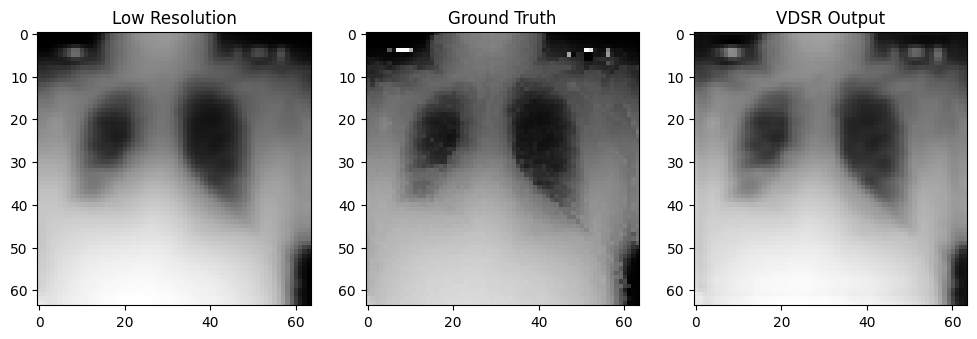

In [ ]:
# Enhancing Medical Image Quality Using SRCNN and VDSR
# Optimized for faster execution and runs both models

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import kagglehub

if __name__ == '__main__':

    # ---------------------------------------------
    # 1. Dataset Loading and Preprocessing
    # ---------------------------------------------

    # Download NIH Chest X-ray sample dataset using kagglehub
    DATASET_PATH = kagglehub.dataset_download("nih-chest-xrays/sample")
    print("Path to dataset files:", DATASET_PATH)

    IMG_SIZE = 64  # Reduced image size for faster processing
    LIMIT = 200    # Smaller subset for quicker training

    def load_images(path, limit=None):
        images = []
        for root, _, files in os.walk(path):
            for fname in files[:limit] if limit else files:
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(os.path.join(root, fname), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        images.append(img.astype(np.float32) / 255.0)
        return np.array(images)

    # Simulate low-res by downscaling and upscaling
    def degrade_images(hr_images):
        lr_images = []
        for img in hr_images:
            low_res = cv2.resize(img, (IMG_SIZE // 2, IMG_SIZE // 2))
            upscaled = cv2.resize(low_res, (IMG_SIZE, IMG_SIZE))
            lr_images.append(upscaled)
        return np.array(lr_images)

    # Load dataset
    all_images = load_images(DATASET_PATH, limit=LIMIT)
    lr_images = degrade_images(all_images)

    # Train-test split
    split = int(0.8 * len(all_images))
    x_train, x_test = lr_images[:split], lr_images[split:]
    y_train, y_test = all_images[:split], all_images[split:]

    # ---------------------------------------------
    # 2. Model Definitions
    # ---------------------------------------------

    # SRCNN Model
    def build_srcnn():
        inp = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
        x = Conv2D(64, (9, 9), activation='relu', padding='same')(inp)
        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        out = Conv2D(1, (5, 5), activation='linear', padding='same')(x)
        return Model(inputs=inp, outputs=out)

    # VDSR Model (reduced depth for speed)
    def build_vdsr():
        inp = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
        x = inp
        for _ in range(10):  # Fewer layers for faster training
            x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        out = Conv2D(1, (3, 3), activation='linear', padding='same')(x)
        out = tf.keras.layers.Add()([inp, out])  # Residual connection
        return Model(inputs=inp, outputs=out)

    # ---------------------------------------------
    # 3. Training & Evaluation
    # ---------------------------------------------

    def evaluate_model(model, x_test, y_test):
        psnr_scores = []
        ssim_scores = []
        for i in range(len(x_test)):
            input_img = x_test[i][..., np.newaxis][np.newaxis, ...]
            output_img = model.predict(input_img, verbose=0)[0, ..., 0]
            gt_img = y_test[i]
            psnr_scores.append(psnr(gt_img, output_img, data_range=1.0))
            ssim_scores.append(ssim(gt_img, output_img, data_range=1.0))
        return np.mean(psnr_scores), np.mean(ssim_scores)

    def show_results(model, x_test, y_test, index, title):
        input_img = x_test[index]
        gt_img = y_test[index]
        pred_img = model.predict(input_img[np.newaxis, ..., np.newaxis])[0, ..., 0]

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(input_img, cmap='gray'); ax[0].set_title('Low Resolution')
        ax[1].imshow(gt_img, cmap='gray'); ax[1].set_title('Ground Truth')
        ax[2].imshow(pred_img, cmap='gray'); ax[2].set_title(f'{title} Output')
        plt.show()

    for model_type in ["SRCNN", "VDSR"]:
        print(f"\nRunning {model_type}...\n")
        model = build_vdsr() if model_type == "VDSR" else build_srcnn()
        model.compile(optimizer=Adam(1e-4), loss='mse')

        model.fit(
            x_train[..., np.newaxis], y_train[..., np.newaxis],
            epochs=5,
            batch_size=8,
            validation_split=0.1,
            verbose=2
        )

        mean_psnr, mean_ssim = evaluate_model(model, x_test, y_test)
        print(f"Model: {model_type}, PSNR: {mean_psnr:.2f}, SSIM: {mean_ssim:.4f}")

        show_results(model, x_test, y_test, 0, model_type)


Path to dataset files: /kaggle/input/chest-xray-pneumonia

Running SRCNN...

Epoch 1/5
147/147 - 77s - 527ms/step - loss: 0.0216 - val_loss: 0.0030
Epoch 2/5
147/147 - 79s - 538ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 3/5
147/147 - 82s - 555ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/5
147/147 - 71s - 483ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/5
147/147 - 72s - 490ms/step - loss: 0.0020 - val_loss: 0.0018
Model: SRCNN, PSNR: 27.13, SSIM: 0.8868
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


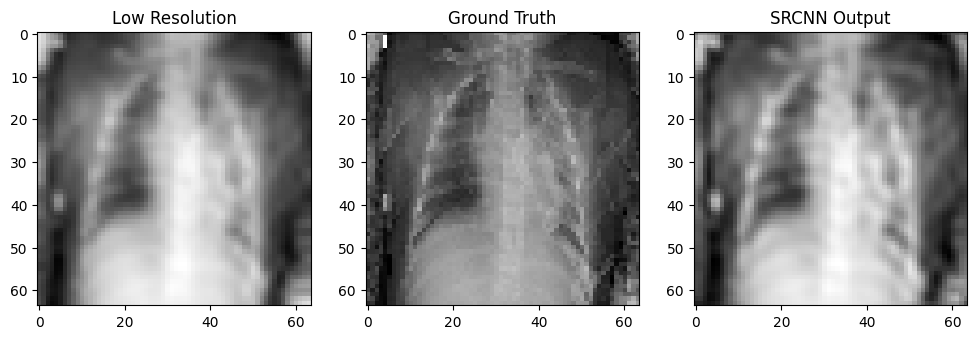


Running VDSR...

Epoch 1/5
147/147 - 264s - 2s/step - loss: 0.0018 - val_loss: 0.0015
Epoch 2/5
147/147 - 256s - 2s/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/5
147/147 - 263s - 2s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/5
147/147 - 265s - 2s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/5
147/147 - 261s - 2s/step - loss: 0.0014 - val_loss: 0.0013
Model: VDSR, PSNR: 28.48, SSIM: 0.9133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


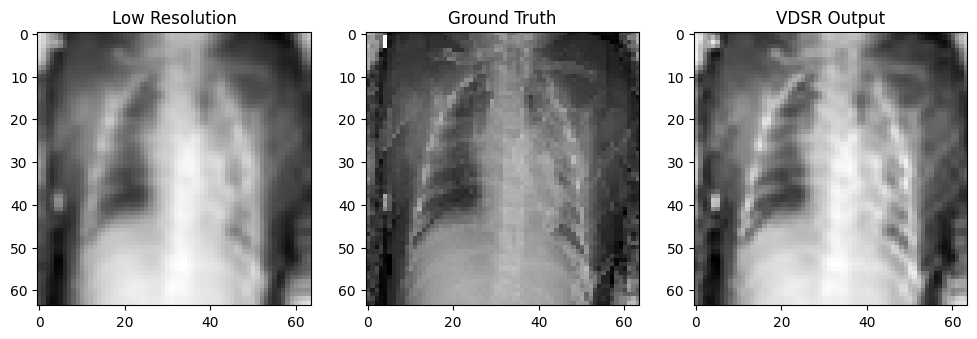

In [ ]:
# Enhancing Medical Image Quality Using SRCNN and VDSR
# Optimized for faster execution and runs both models

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import kagglehub

if __name__ == '__main__':

    # ---------------------------------------------
    # 1. Dataset Loading and Preprocessing
    # ---------------------------------------------

    # Download Chest X-ray Pneumonia dataset using kagglehub
    DATASET_PATH = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
    print("Path to dataset files:", DATASET_PATH)

    IMG_SIZE = 64  # Reduced image size for faster processing
    LIMIT = 200    # Smaller subset for quicker training

    def load_images(path, limit=None):
        images = []
        for root, _, files in os.walk(path):
            for fname in files[:limit] if limit else files:
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(os.path.join(root, fname), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        images.append(img.astype(np.float32) / 255.0)
        return np.array(images)

    # Simulate low-res by downscaling and upscaling
    def degrade_images(hr_images):
        lr_images = []
        for img in hr_images:
            low_res = cv2.resize(img, (IMG_SIZE // 2, IMG_SIZE // 2))
            upscaled = cv2.resize(low_res, (IMG_SIZE, IMG_SIZE))
            lr_images.append(upscaled)
        return np.array(lr_images)

    # Load dataset
    all_images = load_images(DATASET_PATH, limit=LIMIT)
    lr_images = degrade_images(all_images)

    # Train-test split
    split = int(0.8 * len(all_images))
    x_train, x_test = lr_images[:split], lr_images[split:]
    y_train, y_test = all_images[:split], all_images[split:]

    # ---------------------------------------------
    # 2. Model Definitions
    # ---------------------------------------------

    # SRCNN Model
    def build_srcnn():
        inp = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
        x = Conv2D(64, (9, 9), activation='relu', padding='same')(inp)
        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        out = Conv2D(1, (5, 5), activation='linear', padding='same')(x)
        return Model(inputs=inp, outputs=out)

    # VDSR Model (reduced depth for speed)
    def build_vdsr():
        inp = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
        x = inp
        for _ in range(10):  # Fewer layers for faster training
            x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        out = Conv2D(1, (3, 3), activation='linear', padding='same')(x)
        out = tf.keras.layers.Add()([inp, out])  # Residual connection
        return Model(inputs=inp, outputs=out)

    # ---------------------------------------------
    # 3. Training & Evaluation
    # ---------------------------------------------

    def evaluate_model(model, x_test, y_test):
        psnr_scores = []
        ssim_scores = []
        for i in range(len(x_test)):
            input_img = x_test[i][..., np.newaxis][np.newaxis, ...]
            output_img = model.predict(input_img, verbose=0)[0, ..., 0]
            gt_img = y_test[i]
            psnr_scores.append(psnr(gt_img, output_img, data_range=1.0))
            ssim_scores.append(ssim(gt_img, output_img, data_range=1.0))
        return np.mean(psnr_scores), np.mean(ssim_scores)

    def show_results(model, x_test, y_test, index, title):
        input_img = x_test[index]
        gt_img = y_test[index]
        pred_img = model.predict(input_img[np.newaxis, ..., np.newaxis])[0, ..., 0]

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(input_img, cmap='gray'); ax[0].set_title('Low Resolution')
        ax[1].imshow(gt_img, cmap='gray'); ax[1].set_title('Ground Truth')
        ax[2].imshow(pred_img, cmap='gray'); ax[2].set_title(f'{title} Output')
        plt.show()

    for model_type in ["SRCNN", "VDSR"]:
        print(f"\nRunning {model_type}...\n")
        model = build_vdsr() if model_type == "VDSR" else build_srcnn()
        model.compile(optimizer=Adam(1e-4), loss='mse')

        model.fit(
            x_train[..., np.newaxis], y_train[..., np.newaxis],
            epochs=5,
            batch_size=8,
            validation_split=0.1,
            verbose=2
        )

        mean_psnr, mean_ssim = evaluate_model(model, x_test, y_test)
        print(f"Model: {model_type}, PSNR: {mean_psnr:.2f}, SSIM: {mean_ssim:.4f}")

        show_results(model, x_test, y_test, 0, model_type)


100%|██████████| 1.19G/1.19G [00:17<00:00, 71.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/praveengovi/coronahack-chest-xraydataset/versions/3

Running SRCNN...

Epoch 1/5
36/36 - 21s - 587ms/step - loss: 0.0602 - val_loss: 0.0164
Epoch 2/5
36/36 - 19s - 534ms/step - loss: 0.0099 - val_loss: 0.0066
Epoch 3/5
36/36 - 20s - 557ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 4/5
36/36 - 20s - 547ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 5/5
36/36 - 21s - 584ms/step - loss: 0.0028 - val_loss: 0.0025
Model: SRCNN, PSNR: 26.14, SSIM: 0.8533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


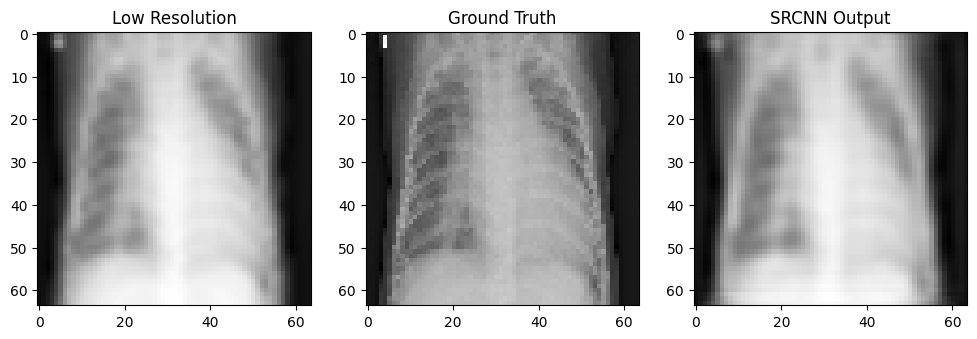


Running VDSR...

Epoch 1/5
36/36 - 66s - 2s/step - loss: 0.0020 - val_loss: 0.0018
Epoch 2/5
36/36 - 82s - 2s/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/5
36/36 - 82s - 2s/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/5
36/36 - 84s - 2s/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/5
36/36 - 82s - 2s/step - loss: 0.0016 - val_loss: 0.0015
Model: VDSR, PSNR: 28.46, SSIM: 0.9164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


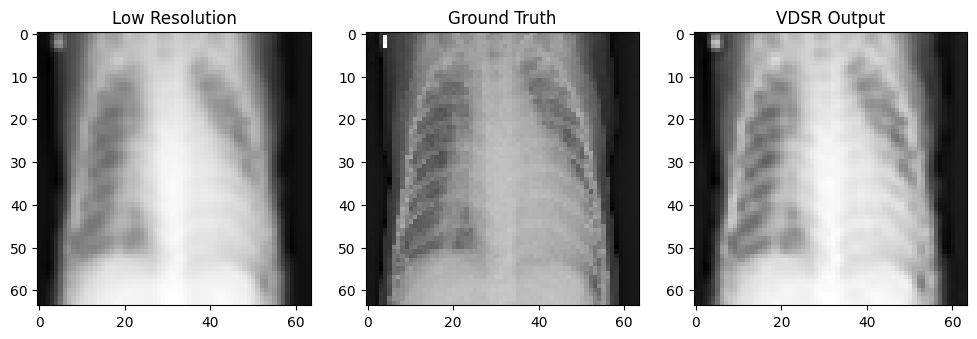

In [ ]:
# Enhancing Medical Image Quality Using SRCNN and VDSR
# Optimized for faster execution and runs both models

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import kagglehub

if __name__ == '__main__':

    # ---------------------------------------------
    # 1. Dataset Loading and Preprocessing
    # ---------------------------------------------

    # Download Coronahack Chest X-ray dataset using kagglehub
    DATASET_PATH = kagglehub.dataset_download("praveengovi/coronahack-chest-xraydataset")
    print("Path to dataset files:", DATASET_PATH)

    IMG_SIZE = 64  # Reduced image size for faster processing
    LIMIT = 200    # Smaller subset for quicker training

    def load_images(path, limit=None):
        images = []
        for root, _, files in os.walk(path):
            for fname in files[:limit] if limit else files:
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(os.path.join(root, fname), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        images.append(img.astype(np.float32) / 255.0)
        return np.array(images)

    # Simulate low-res by downscaling and upscaling
    def degrade_images(hr_images):
        lr_images = []
        for img in hr_images:
            low_res = cv2.resize(img, (IMG_SIZE // 2, IMG_SIZE // 2))
            upscaled = cv2.resize(low_res, (IMG_SIZE, IMG_SIZE))
            lr_images.append(upscaled)
        return np.array(lr_images)

    # Load dataset
    all_images = load_images(DATASET_PATH, limit=LIMIT)
    lr_images = degrade_images(all_images)

    # Train-test split
    split = int(0.8 * len(all_images))
    x_train, x_test = lr_images[:split], lr_images[split:]
    y_train, y_test = all_images[:split], all_images[split:]

    # ---------------------------------------------
    # 2. Model Definitions
    # ---------------------------------------------

    # SRCNN Model
    def build_srcnn():
        inp = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
        x = Conv2D(64, (9, 9), activation='relu', padding='same')(inp)
        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        out = Conv2D(1, (5, 5), activation='linear', padding='same')(x)
        return Model(inputs=inp, outputs=out)

    # VDSR Model (reduced depth for speed)
    def build_vdsr():
        inp = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
        x = inp
        for _ in range(10):  # Fewer layers for faster training
            x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        out = Conv2D(1, (3, 3), activation='linear', padding='same')(x)
        out = tf.keras.layers.Add()([inp, out])  # Residual connection
        return Model(inputs=inp, outputs=out)

    # ---------------------------------------------
    # 3. Training & Evaluation
    # ---------------------------------------------

    def evaluate_model(model, x_test, y_test):
        psnr_scores = []
        ssim_scores = []
        for i in range(len(x_test)):
            input_img = x_test[i][..., np.newaxis][np.newaxis, ...]
            output_img = model.predict(input_img, verbose=0)[0, ..., 0]
            gt_img = y_test[i]
            psnr_scores.append(psnr(gt_img, output_img, data_range=1.0))
            ssim_scores.append(ssim(gt_img, output_img, data_range=1.0))
        return np.mean(psnr_scores), np.mean(ssim_scores)

    def show_results(model, x_test, y_test, index, title):
        input_img = x_test[index]
        gt_img = y_test[index]
        pred_img = model.predict(input_img[np.newaxis, ..., np.newaxis])[0, ..., 0]

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(input_img, cmap='gray'); ax[0].set_title('Low Resolution')
        ax[1].imshow(gt_img, cmap='gray'); ax[1].set_title('Ground Truth')
        ax[2].imshow(pred_img, cmap='gray'); ax[2].set_title(f'{title} Output')
        plt.show()

    for model_type in ["SRCNN", "VDSR"]:
        print(f"\nRunning {model_type}...\n")
        model = build_vdsr() if model_type == "VDSR" else build_srcnn()
        model.compile(optimizer=Adam(1e-4), loss='mse')

        model.fit(
            x_train[..., np.newaxis], y_train[..., np.newaxis],
            epochs=5,
            batch_size=8,
            validation_split=0.1,
            verbose=2
        )

        mean_psnr, mean_ssim = evaluate_model(model, x_test, y_test)
        print(f"Model: {model_type}, PSNR: {mean_psnr:.2f}, SSIM: {mean_ssim:.4f}")

        show_results(model, x_test, y_test, 0, model_type)


<h3> PSNR & SSIM Comparison Across Datasets</h3>

<table border="1" cellpadding="8" cellspacing="0">
  <thead>
    <tr>
      <th>Model</th>
      <th>Dataset 1<br>(PSNR / SSIM)</th>
      <th>Dataset 2<br>(PSNR / SSIM)</th>
      <th>Dataset 3<br>(PSNR / SSIM)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>SRCNN</strong></td>
      <td>25.85 / 0.8729</td>
      <td>27.13 / 0.8868</td>
      <td>26.14 / 0.8533</td>
    </tr>
    <tr>
      <td><strong>VDSR</strong></td>
      <td>28.87 / 0.9273</td>
      <td>28.48 / 0.9133</td>
      <td>28.46 / 0.9164</td>
    </tr>
  </tbody>
</table>

Across all three datasets, VDSR yields higher PSNR and SSIM. SRCNN shows more variation in SSIM and PSNR across datasets. The VDSR took a lot more time fro each datset. Overall, use VDSR when computational resources allow. SRCNN might be acceptable for simpler tasks or limited environments, but with noticeable quality loss.